In [21]:
# !pip install --upgrade pip --quiet
# !pip install -r requirements.txt --quiet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score as roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score as auc
# from catboost import Pool, CatBoostClassifier
import pprint
from sklearn.linear_model import LogisticRegression


In [7]:
current_file = ""

csv_filename = os.path.join(current_file, './cleaned_data/train_data.csv')
train_data = pd.read_csv(csv_filename)

csv_filename = os.path.join(current_file, '../test_data/test_QyjYwdj.csv')
test_data = pd.read_csv(csv_filename)


csv_filename = os.path.join(current_file, './feature_set/campaign_based_features.csv')
campaign_based_features = pd.read_csv(csv_filename)

csv_filename = os.path.join(current_file, './feature_set/customer_based_features.csv')
customer_based_features = pd.read_csv(csv_filename)

csv_filename = os.path.join(current_file, './feature_set/coupon_based_features.csv')
coupon_based_features = pd.read_csv(csv_filename)

csv_filename = os.path.join(current_file, './feature_set/campaign_coupon_features.csv')
campaign_coupon_features = pd.read_csv(csv_filename)

csv_filename = os.path.join(current_file, './feature_set/campaign_customer_features.csv')
campaign_customer_features = pd.read_csv(csv_filename)

csv_filename = os.path.join(current_file, './feature_set/coupon_customer_features.csv')
coupon_customer_features = pd.read_csv(csv_filename)

In [8]:
def print_evaluation_matrix(actual_values, predictions, predictions_probability):
    print(confusion_matrix(actual_values, predictions))
    print(roc_auc_score(actual_values, pd.DataFrame(predictions_probability)))


In [9]:
!mkdir submissions

def save_submission(test_data, predictions_probability, file_name = str(int(time.time()))):
    predictions_probability = predictions_probability
    submission_df = pd.concat([test_data['id'], pd.Series(predictions_probability, name="redemption_status")], axis=1)

    submission_file_name = "submissions/" + file_name + ".csv"

    submission_df.to_csv(submission_file_name, index=False)

mkdir: submissions: File exists


In [10]:
def over_sample(df, column_name, column_value, multiplier=2):
    oversampled_df = df
    for i in range(multiplier):
        oversampled_df = pd.concat([ oversampled_df, df.loc[(df[column_name] == column_value)] ])
    return oversampled_df

# Joining features to create test_data_to_be_used

In [11]:
train_data_to_be_used = train_data

train_data_to_be_used = train_data_to_be_used\
.merge(campaign_based_features, on=['campaign_id'], how='left')

train_data_to_be_used = train_data_to_be_used\
.merge(customer_based_features, on=['customer_id'], how='left')

train_data_to_be_used = train_data_to_be_used\
.merge(coupon_based_features, on=['coupon_id'], how='left')

train_data_to_be_used = train_data_to_be_used\
.merge(campaign_coupon_features, on=['campaign_id', 'coupon_id'], how='left')

train_data_to_be_used = train_data_to_be_used\
.merge(campaign_customer_features, on=['campaign_id', 'customer_id'], how='left')

train_data_to_be_used = train_data_to_be_used\
.merge(coupon_customer_features, on=['coupon_id', 'customer_id'], how='left')

In [12]:
test_data_to_be_used = test_data

test_data_to_be_used = test_data_to_be_used\
.merge(campaign_based_features, on=['campaign_id'], how='left')

test_data_to_be_used = test_data_to_be_used\
.merge(customer_based_features, on=['customer_id'], how='left')

test_data_to_be_used = test_data_to_be_used\
.merge(coupon_based_features, on=['coupon_id'], how='left')

test_data_to_be_used = test_data_to_be_used\
.merge(campaign_coupon_features, on=['campaign_id', 'coupon_id'], how='left')

test_data_to_be_used = test_data_to_be_used\
.merge(campaign_customer_features, on=['campaign_id', 'customer_id'], how='left')

test_data_to_be_used = test_data_to_be_used\
.merge(coupon_customer_features, on=['coupon_id', 'customer_id'], how='left')


In [13]:
# Over-sample based on redemption_status column and value 1.
train_data_to_be_used = over_sample(df=train_data_to_be_used, \
                                    column_name='redemption_status', column_value=1, multiplier=10)

In [14]:
# Drop the id columns
train_data_to_be_used = train_data_to_be_used.drop(columns=['campaign_id', 'customer_id', 'coupon_id'])
test_data_to_be_used = test_data_to_be_used.drop(columns=['campaign_id', 'customer_id', 'coupon_id'])

In [15]:
# Fill all null values with 0
train_data_to_be_used = train_data_to_be_used.fillna(0)
test_data_to_be_used = test_data_to_be_used.fillna(0)

In [16]:
# Drop id and label, and extract only feature dataframe.
train_features = train_data_to_be_used.drop(columns=['id', 'redemption_status'])
test_features = test_data_to_be_used.drop(columns=['id'])

# Get target labels of train set.
train_target = train_data_to_be_used['redemption_status']
                                            
    

# Model Training

## Model Definitions

In [17]:
def run_random_forest(train_X, train_y, val_X, val_y, test_X, hyper_paramaters):
    print('Train run_RandomForest')
    model = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=0)
    model.fit(train_X, train_y)
    
    print('Predict 1/2')
    pred_val_y = model.predict(val_X)
    pred_val_prob = model.predict_proba(val_X)[:, 1]
    
    print('Predict 2/2')
    pred_test_prob = model.predict_proba(test_X)[:, 1]

    coef = pd.Series(model.feature_importances_)

    columns = pd.Series(train_X.columns)
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = columns
    feature_importance['coef'] = coef
        
    print_evaluation_matrix(val_y, pred_val_y, pred_val_prob)
    
    return pred_val_prob, pred_test_prob, feature_importance

In [18]:
def run_logistic_regression(train_X, train_y, val_X, val_y, test_X, hyper_paramaters):
    print('Train LR')
    model = LogisticRegression(**hyper_paramaters)
    model.fit(train_X, train_y)
    
    print('Predict 1/2')
    pred_val_y = model.predict(val_X)
    pred_val_prob = model.predict_proba(val_X)[:, 1]
    
    print('Predict 2/2')
    pred_test_prob = model.predict_proba(test_X)[:, 1]

    coef = pd.Series(model.coef_[0])

    columns = pd.Series(train_X.columns)
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = columns
    feature_importance['coef'] = coef
        
    print_evaluation_matrix(val_y, pred_val_y, pred_val_prob)
    
    return pred_val_prob, pred_test_prob, feature_importance

## Model Running Utility

In [19]:
def run_cv_model(train_features, test_features, train_target, model_function,
                 hyper_parameters={}, evaluation_function=None, label='model', n_folds=5):
    kf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 228)
    fold_splits = kf.split(train_features, train_target)

    cv_scores = []
    test_pred_sum = 0
    train_pred = np.zeros((train_features.shape[0]))
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = test_features.columns

    i = 1
    for train_index, val_index in fold_splits:
        print(len(train_index))
        print(len(val_index))
        print('-------------------------------------------')
        print('Started ' + label + ' fold: ' + str(i) + f'/{n_folds}')
        train_X, val_X = train_features.iloc[train_index], train_features.iloc[val_index]
        train_y, val_y = train_target.iloc[train_index], train_target.iloc[val_index]
        
        hyper_parameters_copy = hyper_parameters.copy()
        val_pred, test_pred, feature_importance = model_function(train_X, train_y, val_X, val_y,
                                                                     test_features, hyper_parameters_copy)
        
        feature_importance = feature_importance.rename(columns={"coef": f'fold_{i}'})
        feature_importances = feature_importances.merge(feature_importance)

        test_pred_sum = test_pred_sum + test_pred
        train_pred[val_index] = val_pred
        

        if evaluation_function is not None:
            cv_score = evaluation_function(val_y, val_pred)
            cv_scores.append(cv_score)
            print(label + ' cv_score {}: {}'.format(i, cv_score), '\n')
        i += 1

    print('\n{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    
    test_pred_avg = test_pred_sum / n_folds
    
    feature_importances['importance'] = feature_importances.drop(columns=['feature']).mean(axis = 1)

    results = {
        'label': label,
        'train_pred': train_pred, 
        'test_pred': test_pred,
        'cv': cv_scores, 
        'feature_importances': feature_importances[['feature', 'importance']]
    }
    
    print("\n\n")
    pprint.pprint(results)
    return results

### Model Validation - Logistic Regression

In [50]:
lr_params = {
    'solver': 'liblinear',
    'C': 0.8,
    'max_iter' : 3500,
    'class_weight': 'balanced'
}

results = run_cv_model(train_features, test_features, train_target, run_logistic_regression, \
                       lr_params, auc, 'Logistic Regression')

68527
17132
-------------------------------------------
Started Logistic Regression fold: 1/5
Train LR
Predict 1/2
Predict 2/2
[[14153  1375]
 [  249  1355]]
0.9388147956679656
Logistic Regression cv_score 1: 0.9388147956679656 

68527
17132
-------------------------------------------
Started Logistic Regression fold: 2/5
Train LR
Predict 1/2
Predict 2/2
[[14185  1343]
 [  289  1315]]
0.9319579641185547
Logistic Regression cv_score 2: 0.9319579641185547 

68527
17132
-------------------------------------------
Started Logistic Regression fold: 3/5
Train LR
Predict 1/2
Predict 2/2
[[14261  1267]
 [  308  1296]]
0.9331007392646667
Logistic Regression cv_score 3: 0.9331007392646667 

68527
17132
-------------------------------------------
Started Logistic Regression fold: 4/5
Train LR
Predict 1/2
Predict 2/2
[[14196  1332]
 [  279  1325]]
0.9387767138696278
Logistic Regression cv_score 4: 0.9387767138696278 

68528
17131
-------------------------------------------
Started Logistic Regress

In [ ]:
save_submission(test_data_to_be_used, results['test_pred'], file_name="logistic_regression")

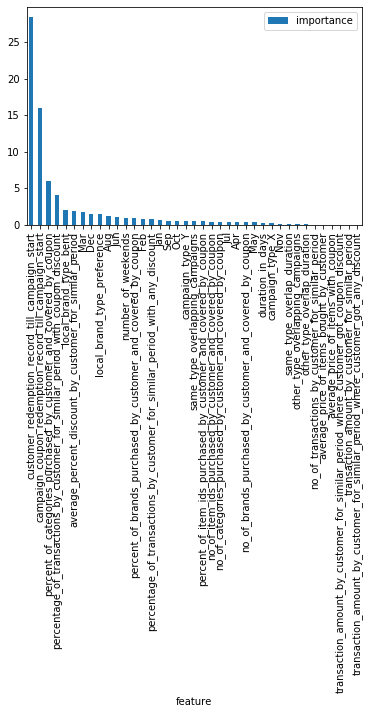

In [51]:
results['feature_importances_abs'] = results['feature_importances'][['feature', 'importance']]
results['feature_importances_abs']['importance'] = abs(results['feature_importances_abs']['importance'])
results['feature_importances_abs'].sort_values(['importance'], ascending=False)\
.plot.bar(x='feature', y='importance', rot=90, )

### Model Validation - Random Forest

In [52]:
rf_params = {
}

results = run_cv_model(train_features, test_features, train_target, run_random_forest, \
                       rf_params, auc, 'Random Forest')

68527
17132
-------------------------------------------
Started Random Forest fold: 1/5
Train run_RandomForest
Predict 1/2
Predict 2/2
[[15449    79]
 [  750   854]]
0.9834433911357618
Random Forest cv_score 1: 0.9834433911357618 

68527
17132
-------------------------------------------
Started Random Forest fold: 2/5
Train run_RandomForest
Predict 1/2
Predict 2/2
[[15454    74]
 [  756   848]]
0.9817510697432102
Random Forest cv_score 2: 0.9817510697432102 

68527
17132
-------------------------------------------
Started Random Forest fold: 3/5
Train run_RandomForest
Predict 1/2
Predict 2/2
[[15470    58]
 [  754   850]]
0.9814236305167016
Random Forest cv_score 3: 0.9814236305167016 

68527
17132
-------------------------------------------
Started Random Forest fold: 4/5
Train run_RandomForest
Predict 1/2
Predict 2/2
[[15463    65]
 [  738   866]]
0.9817664470007361
Random Forest cv_score 4: 0.9817664470007361 

68528
17131
-------------------------------------------
Started Random F

In [25]:
save_submission(test_data_to_be_used, results['test_pred'], file_name="random_forest")

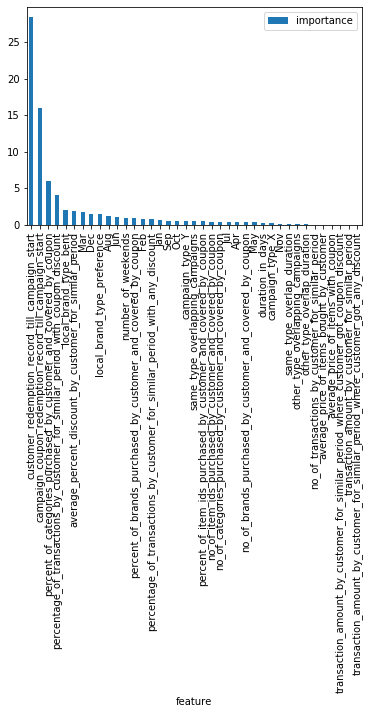

In [48]:
results['feature_importances_abs'] = results['feature_importances'][['feature', 'importance']]
results['feature_importances_abs']['importance'] = abs(results['feature_importances_abs']['importance'])
results['feature_importances_abs'].sort_values(['importance'], ascending=False)\
.plot.bar(x='feature', y='importance', rot=90, )